In [1]:
import matplotlib.pyplot as plt
import torch

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Bigram model
- Main idea: to determine the likelihood of the next char appeared, given only the previous char
- Approach: use normalized count from dataset to predict the probability of the next char
- Technique: use dictionary to store diagram - count pair, then normalize to get the probability. 
- Loss function: negative log likelihood

In [13]:
b = {} # dictionary to store biagram to see how likely the 2 chars appear together
for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [16]:
sorted(b.items(), key = lambda kv: -kv[1]) # sort in reverse by value, not key

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

### Using Pytorch

In [22]:
# create a 28x28 array (28 = 26 normal chars + 2 special chars <S> and <E>)
# row represents the initial char, and col represents the likelihood of the next char
N = torch.zeros((28,28), dtype = torch.int32)

In [31]:
chars = sorted(list(set(''.join(words)))) # create alphabetical list
stoi = {s:i for i,s in enumerate(chars)}  # create lookup table to match letter s to its index no. in the alphabet: s to i
stoi['<S>'] = 26
stoi['<E>'] = 27

In [27]:
for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2]  += 1

In [33]:
itos = {i:s for s, i in stoi.items()} # new lookup table where key = index, value = char

In [37]:
N[1,1].item()

38

(-0.5, 27.5, 27.5, -0.5)

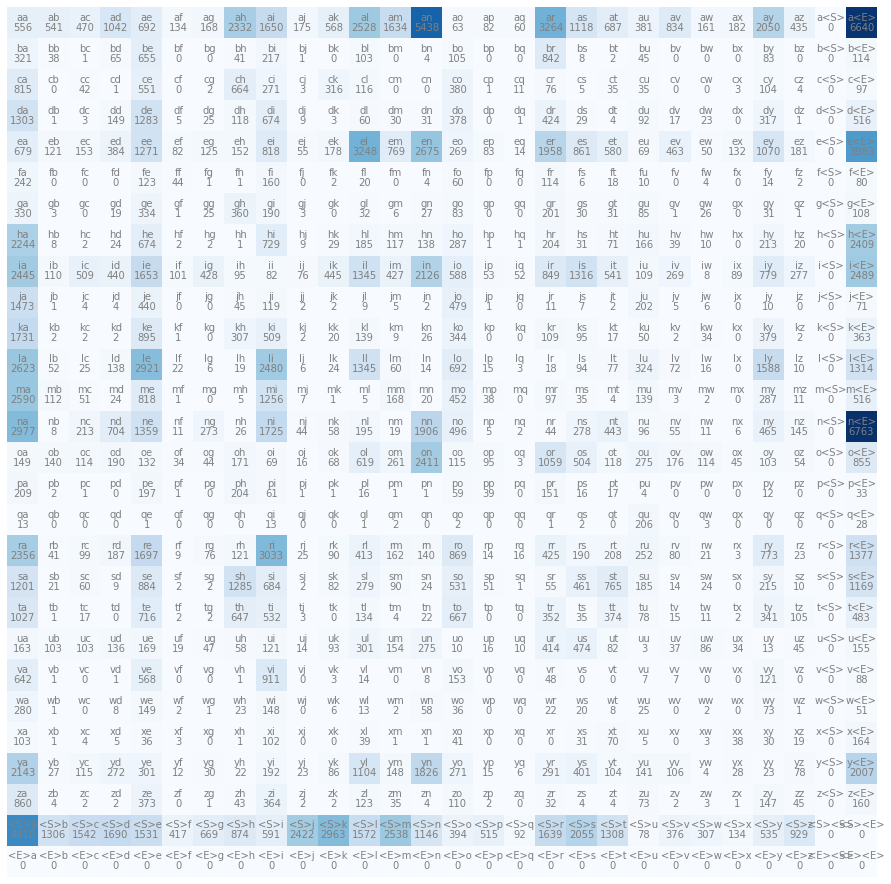

In [39]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

### Update table
replace special tokens `<S>` and `<E>` with `.`

In [40]:
# create a 27x27 array (28 = 26 normal chars + 1 special chars '.')
# row represents the initial char, and col represents the likelihood of the next char
N = torch.zeros((27,27), dtype = torch.int32)

chars = sorted(list(set(''.join(words)))) # create alphabetical list
stoi = {s:i+1 for i,s in enumerate(chars)}  # create lookup table to match letter s to its index no. in the alphabet: s to i
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()} # new lookup table where key = index, value = char

for w in words:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2]  += 1

(-0.5, 26.5, 26.5, -0.5)

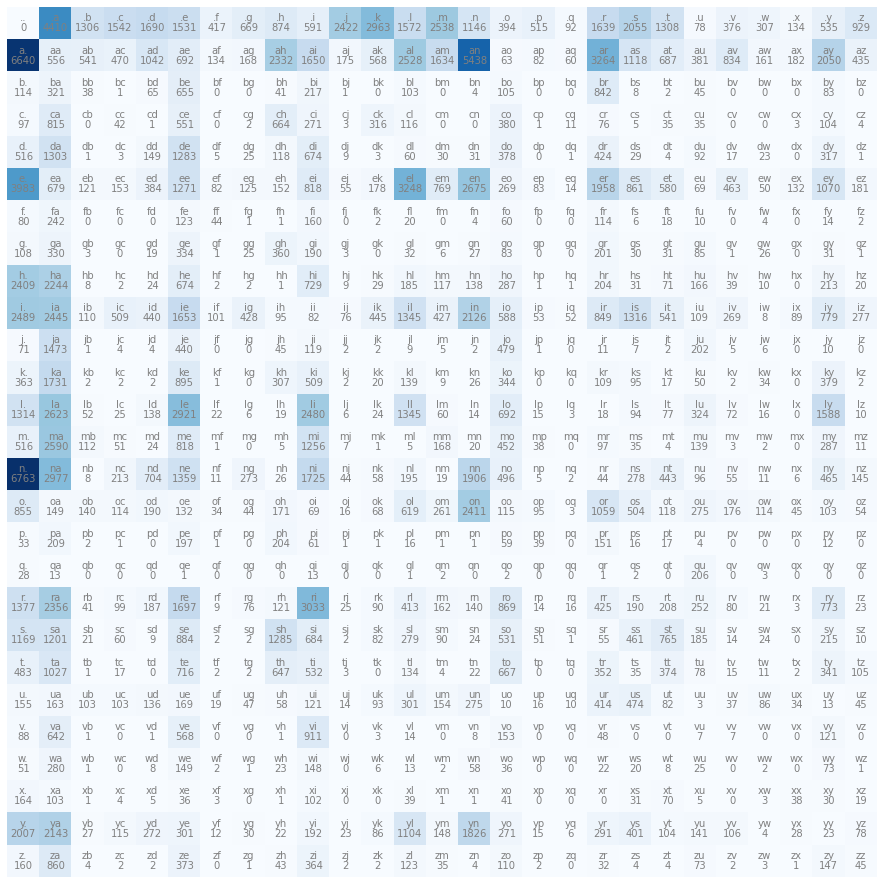

In [41]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

### Probability vector
Probability of the first char by checking probability p of first row N[0]

In [58]:
p = N[0].float() # probability vector p for first char
p = p / p.sum()  # normalize p to get the probability
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [51]:
# Multi-nomial - given the probability vector p
def example_multinomial():
    g = torch.Generator().manual_seed(2147483647)
    p = torch.rand(3, generator=g) # create 3 random numbers between 0 and 1
    p = p / p.sum()
    return torch.multinomial(p, num_samples=20, replacement=True, generator=g)
    # out of 20 samples, 60% should be 0, 30% is 1 and 10% is 2, according to the probability vector p 
example_multinomial()

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [99]:
# Compute the probability vector - convert count N to prob P by normalizing P to its sum
P = N.float()
P /= P.sum(1, keepdim = True) # 1 = sum in horizontal direction (row), keepdim = True to prevent squeezing
P.shape

torch.Size([27, 27])

Relevent concept: 
- `keepdim=True` vs `keepdim=False`
- Broadcasting - https://pytorch.org/docs/stable/notes/broadcasting.html

In [98]:
P.sum(1, keepdim = True).shape, P.sum(1, keepdim=False).shape

(torch.Size([27, 1]), torch.Size([27]))

In [100]:
g = torch.Generator().manual_seed(214748364)

for i in range(10):
    out = []
    ix = 0
    while True:
        # ---- Uniform distribution - base case ---- #
        # p = torch.ones(27)/27 # uniform distribution where every char is equally likely to start - to compare with bigram model

        # ---- Bigram model --- #
        p = P[ix] # probability vector p for first char
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        
        if ix == 0: # end token reached!
            break
    print(''.join(out[:-1]))

bdaita
shely
ka
orcehensiollya
jemana
zamiah
deneyshodan
n
keveyan
ky


Note: bigram is a horrible model, that's why the new names are non-sensical.

### Evaluate the quality of digram model

Loss function = negative log of products of all probabilities
- `log(a*b*c) = log(a) + log(b) + log(c)`
- Probability is between 0 and 1, so `log(prob)` is between `-inf` and `0`, respectively
- `Sum` of `log(prob)` is between `-inf` and `0`
- To minimize loss function function, we get negative of the `sum` of `log(prob)`, so the more error, the higher the loss value


- GOAL: maximize likelihood of the data w.r.t model parameters (statistical modeling)
- equivalent to maximizing the log likelihood (because log is monotonic)
- equivalent to minimizing the negative log likelihood
- equivalent to minimizing the average negative log likelihood

In [107]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood # negative log likelihood
avg_nll = nll / n    # average nll
# print(f'{nll=}', f'{avg_nll=}') # the lower the norm_nll, the higher the quality of the model
avg_nll

tensor(2.4541)

In [120]:
log_likelihood = 0.0
n = 0
for w in ['fd']:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood # negative log likelihood
avg_nll = nll / n    # average (normalized) nll
print(f'{nll=}', f'{avg_nll=}') # the lower the norm_nll, the higher the quality of the model

.f: 0.0130 -4.3414
fd: 0.0000 -inf
d.: 0.0939 -2.3657
nll=tensor(inf) avg_nll=tensor(inf)


### Model Smoothing

- In the above example, combination `fd` has zero prob according to our model --> log is `inf`
- To fix it, we will add a fake count to all to avoid running into `inf` case a.k.a `model smoothing`

In [129]:
# Compute the probability vector - convert count N to prob P by normalizing P to its sum
FAKE_COUNT = 1
N_SMOOTH = N+FAKE_COUNT
P_smooth = N_SMOOTH.float()
P_smooth /= P_smooth.sum(1, keepdim = True) # 1 = sum in horizontal direction (row), keepdim = True to prevent squeezing

(-0.5, 26.5, 26.5, -0.5)

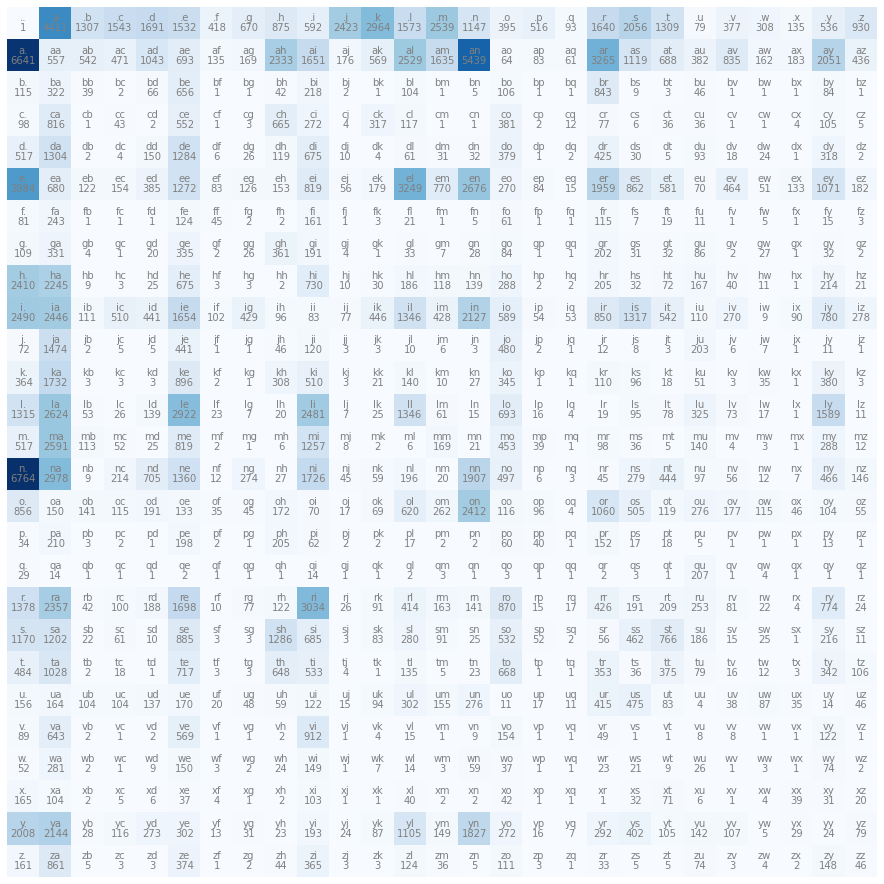

In [128]:
plt.figure(figsize=(16,16))
plt.imshow(N_SMOOTH, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N_SMOOTH[i,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [282]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P_smooth[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood # negative log likelihood
avg_nll = nll / n    # average nll
print(f'{nll=}', f'{avg_nll=}') # the lower the norm_nll, the higher the quality of the model

nll=tensor(559951.5625) avg_nll=tensor(2.4544)


## Bigram model
- Approach: use neural network

#### One-layer neural network
Example on one word to understand the approach

In [204]:
# Create a dataset of biagrams (x,y)
xs, ys = [], [] # xs is the input, ys in the output
for w in words[:1]:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        print(ch1, ch2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


`One-hot encoding for input`
- given there are 27 characters (26 alphabetical + `.`), an int 13 can be represented as a array of 27 elements, with 26 elements of 0 and element 1 at position 13th

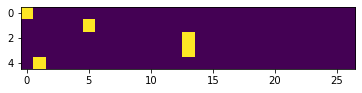

In [205]:
import torch.nn.functional as F
x_enc = F.one_hot(xs, num_classes=27).float() # input to NN should be `float`, not `int`
plt.imshow(x_enc)

In [206]:
x_enc.shape

torch.Size([5, 27])

In [207]:
x_enc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [208]:
# Define 27 neurons' weights, each neuron receives 27 inputs
W = torch.randn((27,27)) # random no. drawn based on normal distribution (# weights, # neurons). each neuron organized by column
W[:,0] # 1st neuron

tensor([-0.2609, -1.8917,  0.8747, -0.3174, -1.6718, -1.0336, -2.9141,  0.4833,
        -2.4402,  0.2236,  0.2407,  0.6369,  0.0487, -0.4427,  1.5920,  1.9006,
        -0.5812,  0.7415,  0.0810, -0.9941, -0.4148,  2.3402, -0.5513,  0.6636,
        -0.8721,  0.6179, -0.2382])

In [210]:
(x_enc[0]*W[:,0]).sum() # equal to dot product of 12th input and 3rd neuron
# given one-hot encoding, the only weight matters is where the input element = 1 (other input elements = 0)

tensor(-0.2609)

In [211]:
(x_enc @ W)

tensor([[-0.2609,  0.7817,  0.3879,  0.3558, -2.2483, -0.2171,  1.1608, -1.1001,
         -1.2887,  1.1937, -0.3484,  0.0171, -1.3644,  1.2688, -0.4977, -0.4766,
         -0.7918, -1.5286, -1.2941, -1.7832,  0.0779,  1.6332, -1.0127, -0.0978,
         -0.1444, -0.5665,  0.8494],
        [-1.0336, -0.4031,  0.6399,  0.2564,  0.1289,  0.5316,  1.4909, -0.9028,
          0.6292, -0.6483,  0.3269, -0.5858,  0.4356,  2.0615,  1.1827,  0.7882,
         -0.0194,  0.9803, -0.1359,  0.1022, -1.8141,  0.1096, -0.0485, -0.5327,
         -0.2065,  0.9364, -0.3457],
        [-0.4427,  1.7223,  1.4209, -0.8328, -0.7838, -0.4903, -0.9781,  0.4158,
          0.3081, -1.5233, -0.4032, -1.6512, -0.8166,  0.5192, -1.7049,  0.3567,
          1.2015,  1.2683, -1.2799,  1.1831, -1.6998,  0.6771, -1.5938,  0.5245,
         -0.3917, -2.5319, -0.0509],
        [-0.4427,  1.7223,  1.4209, -0.8328, -0.7838, -0.4903, -0.9781,  0.4158,
          0.3081, -1.5233, -0.4032, -1.6512, -0.8166,  0.5192, -1.7049,  0.3567

In [222]:
# FORWARD PASS
# exponential converts negative numbers to positive numbers < 1
logits = x_enc @ W # log-counts
counts = logits.exp() # equivalent N
prob = counts / counts.sum(1, keepdims=True) # normalized counts
# btw: the last 2 lines here are together called a "softmax"
prob

tensor([[0.0234, 0.0662, 0.0447, 0.0433, 0.0032, 0.0244, 0.0968, 0.0101, 0.0084,
         0.1000, 0.0214, 0.0308, 0.0077, 0.1078, 0.0184, 0.0188, 0.0137, 0.0066,
         0.0083, 0.0051, 0.0328, 0.1552, 0.0110, 0.0275, 0.0262, 0.0172, 0.0709],
        [0.0082, 0.0153, 0.0435, 0.0296, 0.0261, 0.0390, 0.1018, 0.0093, 0.0430,
         0.0120, 0.0318, 0.0128, 0.0354, 0.1801, 0.0748, 0.0504, 0.0225, 0.0611,
         0.0200, 0.0254, 0.0037, 0.0256, 0.0218, 0.0135, 0.0186, 0.0585, 0.0162],
        [0.0178, 0.1550, 0.1146, 0.0120, 0.0126, 0.0170, 0.0104, 0.0420, 0.0377,
         0.0060, 0.0185, 0.0053, 0.0122, 0.0465, 0.0050, 0.0396, 0.0921, 0.0984,
         0.0077, 0.0904, 0.0051, 0.0545, 0.0056, 0.0468, 0.0187, 0.0022, 0.0263],
        [0.0178, 0.1550, 0.1146, 0.0120, 0.0126, 0.0170, 0.0104, 0.0420, 0.0377,
         0.0060, 0.0185, 0.0053, 0.0122, 0.0465, 0.0050, 0.0396, 0.0921, 0.0984,
         0.0077, 0.0904, 0.0051, 0.0545, 0.0056, 0.0468, 0.0187, 0.0022, 0.0263],
        [0.0051, 0.1331,

- `prob` now shows the probability of the next char given the input char (at this stage, it is not trained as loss function is not calculated yet)
- e.g., given `x_enc[0]` input (equivalent to `xs[0]` or char `.`), `prob[0]` shows how likely the next 27 chars come next
- all these operations are differentiable for back propagation

Softmax Activation Function


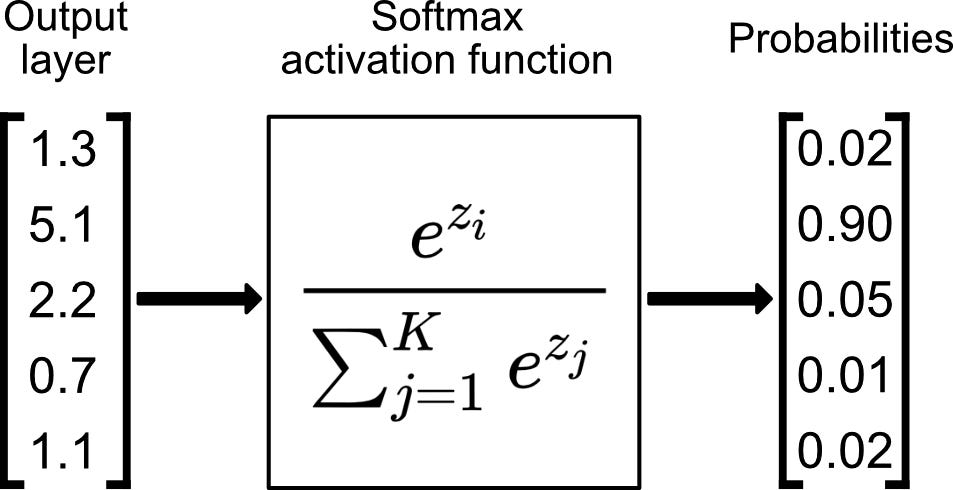

In [223]:
prob.shape

torch.Size([5, 27])

In [226]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th digram
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('-------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print(f'input to the neural net: {x} or char {itos[x]}')
    print('output probabilities from the neural net:', prob[i])
    print(f'label (actual next char): {y} or char {itos[y]}')
    p = prob[i, y]
    print('probability assigned by the net to the correct char:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=======')
print('average neg log likelihood, i.e. loss =', nlls.mean().item())

-------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0 or char .
output probabilities from the neural net: tensor([0.0234, 0.0662, 0.0447, 0.0433, 0.0032, 0.0244, 0.0968, 0.0101, 0.0084,
        0.1000, 0.0214, 0.0308, 0.0077, 0.1078, 0.0184, 0.0188, 0.0137, 0.0066,
        0.0083, 0.0051, 0.0328, 0.1552, 0.0110, 0.0275, 0.0262, 0.0172, 0.0709])
label (actual next char): 5 or char e
probability assigned by the net to the correct char: 0.0243984442204237
log likelihood: -3.713235855102539
negative log likelihood: 3.713235855102539
-------
bigram example 2: em (indexes 5,13)
input to the neural net: 5 or char e
output probabilities from the neural net: tensor([0.0082, 0.0153, 0.0435, 0.0296, 0.0261, 0.0390, 0.1018, 0.0093, 0.0430,
        0.0120, 0.0318, 0.0128, 0.0354, 0.1801, 0.0748, 0.0504, 0.0225, 0.0611,
        0.0200, 0.0254, 0.0037, 0.0256, 0.0218, 0.0135, 0.0186, 0.0585, 0.0162])
label (actual next char): 13 or char m
probability assigned by the net to the correct

#### Optimization

In [259]:
xs

tensor([ 0,  5, 13, 13,  1])

In [260]:
ys

tensor([ 5, 13, 13,  1,  0])

In [261]:
# randomly initialize 27 neurons' weights, each neuron receiving 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad = True) # set requires_grad = True to allow calculation of W grad

In [262]:
# one-hot encoding for input
x_enc = F.one_hot(xs, num_classes=27).float() # input to neural network: one-hot encoding

In [263]:
# gradient descent
for k in range(10):
    # forward pass
    logits = x_enc @ W # prodict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

    # calculate loss - extract the probabilities assigned by the NN at the label position
    # i.e., probs[0, 5] for input 0; probs[1, 13] for input 5; probs[2,13] for input 13; probs[3,1] for input 13; probs[4,0] for input 1]
    # loss = negative avg log
    loss = -probs[torch.arange(5), ys].log().mean()
    print(k, loss.item())

    # backward pass - back propagation
    # reset grad to 0
    W.grad = None
    loss.backward()

    # update data by nudging the data value in opposite direction of grad
    W.data += -10 * W.grad

0 3.7693049907684326
1 1.9317318201065063
2 0.8723701238632202
3 0.5417723059654236
4 0.4438762664794922
5 0.3991290032863617
6 0.3734535574913025
7 0.35676902532577515
8 0.3450435996055603
9 0.3363466262817383


#### Full code

In [273]:
# Create a dataset of biagrams (x,y)
xs, ys = [], [] # xs is the input, ys in the output
for w in words:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [274]:
# one-hot encoding for input
x_enc = F.one_hot(xs, num_classes=27).float() # input to neural network: one-hot encoding

In [275]:
# Initialize the NN with 27 neurons' weights, each neuron receiving 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad = True) # set requires_grad = True to allow calculation of W grad

In [280]:
# gradient descent
for k in range(100):
    # forward pass
    logits = x_enc @ W # prodict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

    # calculate loss - extract the probabilities assigned by the NN at the label position
    # i.e., probs[0, 5] for input 0; probs[1, 13] for input 5; probs[2,13] for input 13; probs[3,1] for input 13; probs[4,0] for input 1]
    # loss = negative avg log
    loss = -probs[torch.arange(num), ys].log().mean()
    print(k, loss.item())

    # backward pass - back propagation
    # reset grad to 0
    W.grad = None
    loss.backward()

    # update data by nudging the data value in opposite direction of grad
    W.data += -10 * W.grad

0 2.486236810684204
1 2.477318286895752
2 2.471008062362671
3 2.466562271118164
4 2.4634909629821777
5 2.4614243507385254
6 2.460069179534912
7 2.4592020511627197
8 2.4586586952209473
9 2.458322286605835
10 2.458115577697754
11 2.457989454269409
12 2.457911729812622
13 2.4578635692596436
14 2.4578328132629395
15 2.457812547683716
16 2.457798957824707
17 2.457789421081543
18 2.457782030105591
19 2.457775831222534
20 2.457771062850952
21 2.457766532897949
22 2.4577627182006836
23 2.4577596187591553
24 2.4577560424804688
25 2.4577529430389404
26 2.457749843597412
27 2.457747220993042
28 2.4577441215515137
29 2.4577414989471436
30 2.4577388763427734
31 2.4577364921569824
32 2.4577341079711914
33 2.4577314853668213
34 2.457728862762451
35 2.4577267169952393
36 2.45772385597229
37 2.457721710205078
38 2.457719564437866
39 2.4577174186706543
40 2.457714796066284
41 2.4577126502990723
42 2.4577102661132812
43 2.4577081203460693
44 2.4577057361602783
45 2.4577035903930664
46 2.4577014446258545


- Compare the loss between `normalized count approach` vs. `neural network approach`: both losses are around `2.45`
- The current neural network is not doing better because it is not having new info, still using only one char to predict the next
- However, neural network approach is much more scalable when we take into account more input characters


#### Sample from NN model

In [284]:
g = torch.Generator().manual_seed(214748364)

for i in range(10):
    out = []
    ix = 0
    while True:
        # ---- Uniform distribution - base case ---- #
        # p = torch.ones(27)/27 # uniform distribution where every char is equally likely to start - to compare with bigram model

        # ---- Bigram model --- #
        p = P[ix] # probability vector p for first char

        # --- Neural network model --- #
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims = True)

        # --------
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        if ix == 0: # end token reached!
            break
    print(''.join(out[:-1]))
    

bdaita
shely
ka
orcehensiollya
jemana
zamiah
deneyshodan
n
keveyan
ky


## Trigram

In [77]:
chars = sorted(list(set(''.join(words)))) # create alphabetical list
chars += '.'
double_chars = []
for c1 in chars:
    for c2 in chars:
        double_chars.append(c1+c2)

In [85]:
N = torch.zeros((27*27,27), dtype = torch.int32)

double_stoi = {s:i for i,s in enumerate(double_chars)}  # create lookup table to match letter s to its index no. in the alphabet: s to i
double_itos = {i:s for s, i in double_stoi.items()} # new lookup table where key = index, value = char

In [68]:
double_stoi

{'aa': 0,
 'ab': 1,
 'ac': 2,
 'ad': 3,
 'ae': 4,
 'af': 5,
 'ag': 6,
 'ah': 7,
 'ai': 8,
 'aj': 9,
 'ak': 10,
 'al': 11,
 'am': 12,
 'an': 13,
 'ao': 14,
 'ap': 15,
 'aq': 16,
 'ar': 17,
 'as': 18,
 'at': 19,
 'au': 20,
 'av': 21,
 'aw': 22,
 'ax': 23,
 'ay': 24,
 'az': 25,
 'a.': 26,
 'ba': 27,
 'bb': 28,
 'bc': 29,
 'bd': 30,
 'be': 31,
 'bf': 32,
 'bg': 33,
 'bh': 34,
 'bi': 35,
 'bj': 36,
 'bk': 37,
 'bl': 38,
 'bm': 39,
 'bn': 40,
 'bo': 41,
 'bp': 42,
 'bq': 43,
 'br': 44,
 'bs': 45,
 'bt': 46,
 'bu': 47,
 'bv': 48,
 'bw': 49,
 'bx': 50,
 'by': 51,
 'bz': 52,
 'b.': 53,
 'ca': 54,
 'cb': 55,
 'cc': 56,
 'cd': 57,
 'ce': 58,
 'cf': 59,
 'cg': 60,
 'ch': 61,
 'ci': 62,
 'cj': 63,
 'ck': 64,
 'cl': 65,
 'cm': 66,
 'cn': 67,
 'co': 68,
 'cp': 69,
 'cq': 70,
 'cr': 71,
 'cs': 72,
 'ct': 73,
 'cu': 74,
 'cv': 75,
 'cw': 76,
 'cx': 77,
 'cy': 78,
 'cz': 79,
 'c.': 80,
 'da': 81,
 'db': 82,
 'dc': 83,
 'dd': 84,
 'de': 85,
 'df': 86,
 'dg': 87,
 'dh': 88,
 'di': 89,
 'dj': 90,
 'dk': 91

In [71]:
chars = sorted(list(set(''.join(words)))) # create alphabetical list
stoi = {s:i for i,s in enumerate(chars)}  # create lookup table to match letter s to its index no. in the alphabet: s to i
stoi['.'] = 26
itos = {i:s for s, i in stoi.items()} # new lookup table where key = index, value = char

In [78]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '.': 26}

In [57]:
N.shape

torch.Size([729, 27])

In [130]:
for w in words:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = double_stoi[ch1+ch2]
        ix2 = stoi[ch3]
        # print(f'input {ch1+ch2} at index {ix1}, output {ch3} at index {ix2}')
        N[ix1, ix2]  += 1

FAKE_COUNT = 1
N_SMOOTH = N+FAKE_COUNT
P_smooth = N_SMOOTH.float()
P_smooth /= P_smooth.sum(1, keepdim = True) # 1 = sum in horizontal direction (row), keepdim = True to prevent squeezing

(-0.5, 26.5, 26.5, -0.5)

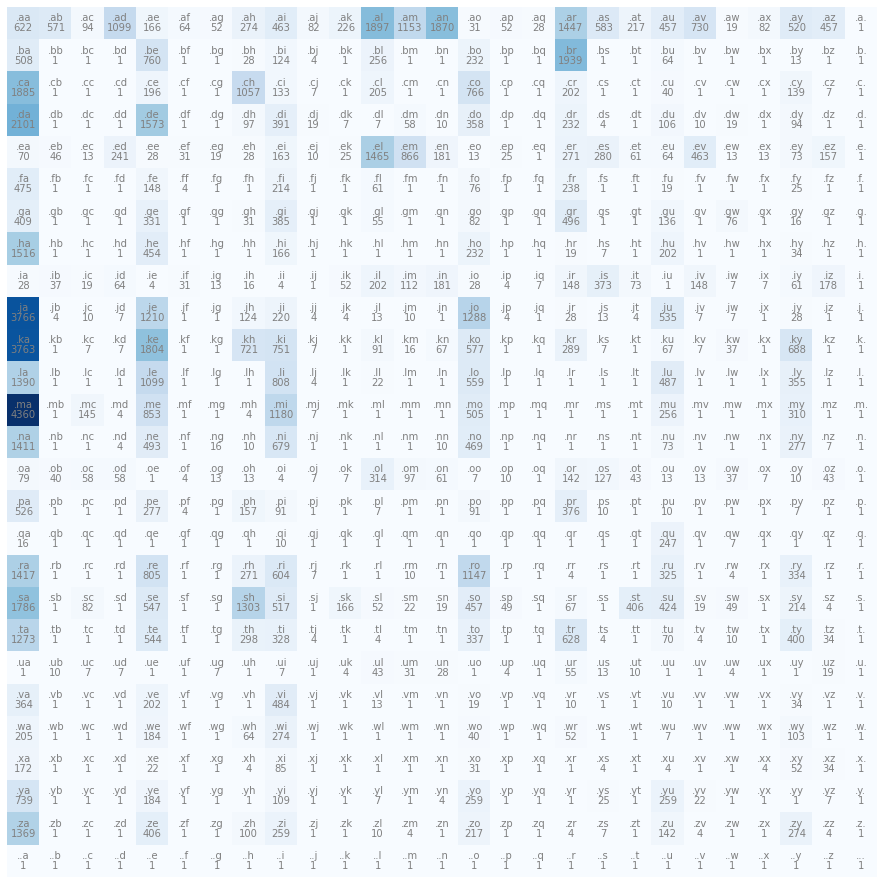

In [154]:
start = 702
N_test = N_SMOOTH[start:start+27,:]

plt.figure(figsize=(16,16))
plt.imshow(N_test, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = double_itos[i+start] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i+start,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [149]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.'] # adding marker <S> and <E> to mark the start & end characters
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = double_stoi[ch1+ch2]
        ix2 = stoi[ch3]
        prob = P_smooth[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood # negative log likelihood
avg_nll = nll / n    # average nll
print(f'{avg_nll=}') # the lower the norm_nll, the higher the quality of the model

avg_nll=tensor(2.0842)


717

#### Sample

In [223]:
g = torch.Generator().manual_seed(214748364)
start_chars = list(double_itos.keys())[702:]

# print(double_itos[ix])
for i in range(10):
    double_ix = start_chars[torch.randint(0,26,(1,)).item()]
    out = [double_itos[double_ix]]
    while True:
        # ---- Trigram model --- #
        p = P_smooth[double_ix] # probability vector p for first char

        # Pick the next char from single letter
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        # Condition to stop
        if itos[ix] == '.': # end token reached!
            break

        # Form with 2 chars for next iteration
        next_2char = ''.join(out)[-2:]
        double_ix = double_stoi[next_2char]
    print(''.join(out))

.yalynerey.
.ar.
.izalenash.
.hivele.
.ramana.
.mana.
.vikann.
.win.
.ley.
.em.
